In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

plt.style.use('seaborn')

file = pd.read_csv('Data.csv', sep=';')
df = pd.DataFrame(file)

In [2]:
def preprocessing(data):

    #Do first stage pre-processing (i.e. exclude non-numeric prices and convert prices to numeric variables)

    data = data[data.price_new.str.contains("aanvraag") == False].dropna()
    data[['price_new']] = data[['price_new']].apply(pd.to_numeric)

    # exclude everything with a price above or below 3 standard deviations (i.e. outliers)

    data = data[np.abs(data["price_new"]-data["price_new"].mean())<=(3*data["price_new"].std())]

    # Set x and y (dropping zipcode and rooms as latitude, longitude and surface pretty much capture the former)

    y = data.price_new
    X = data.drop('price_new', axis = 1).drop('zipcode_new', axis = 1).drop('rooms_new', axis = 1)

    return X, y

def model(pipeline, parameters, X_train, y_train, X, y):

    grid_obj = GridSearchCV(estimator=pipeline,
                            param_grid=parameters,
                            cv=3,
                            scoring='r2',
                            verbose=2,
                            n_jobs=1,
                            refit=True)
    grid_obj.fit(X_train, y_train)

    '''Results'''

    results = pd.DataFrame(pd.DataFrame(grid_obj.cv_results_))
    results_sorted = results.sort_values(by=['mean_test_score'], ascending=False)

    print("##### Results")
    print(results_sorted)

    print("best_index", grid_obj.best_index_)
    print("best_score", grid_obj.best_score_)
    print("best_params", grid_obj.best_params_)

    '''Cross Validation'''

    estimator = grid_obj.best_estimator_
    '''
    if estimator.named_steps['scl'] == True:
        X = (X - X.mean()) / (X.std())
        y = (y - y.mean()) / (y.std())
    '''
    shuffle = KFold(n_splits=5,
                    shuffle=True,
                    random_state=0)
    cv_scores = cross_val_score(estimator,
                                X,
                                y.values.ravel(),
                                cv=shuffle,
                                scoring='r2')
    print("##### CV Results")
    print("mean_score", cv_scores.mean())

    '''Show model coefficients or feature importances'''

    try:
        print("Model coefficients: ", list(zip(list(X), estimator.named_steps['clf'].coef_)))
    except:
        print("Model does not support model coefficients")

    try:
        print("Feature importances: ", list(zip(list(X), estimator.named_steps['clf'].feature_importances_)))
    except:
        print("Model does not support feature importances")

    '''Predict along CV and plot y vs. y_predicted in scatter'''

    y_pred = cross_val_predict(estimator, X, y, cv=shuffle)

    plt.scatter(y, y_pred)
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.plot([xmin, xmax], [ymin, ymax], "g--", lw=1, alpha=0.4)
    plt.xlabel("True prices")
    plt.ylabel("Predicted prices")
    plt.annotate(' R-squared CV = {}'.format(round(float(cv_scores.mean()), 3)), size=9,
             xy=(xmin,ymax), xytext=(10, -15), textcoords='offset points')
    plt.annotate(grid_obj.best_params_, size=9,
                 xy=(xmin, ymax), xytext=(10, -35), textcoords='offset points', wrap=True)
    plt.title('Predicted prices (EUR) vs. True prices (EUR)')
    plt.show()

In [3]:
# Pipeline and Parameters - Linear Regression

pipe_ols = Pipeline([('scl', StandardScaler()),
           ('clf', LinearRegression())])

param_ols = {}
# Pipeline and Parameters - KNN

pipe_knn = Pipeline([('clf', KNeighborsRegressor())])

param_knn = {'clf__n_neighbors':[5, 10, 15, 25, 30]}

In [4]:
# Execute preprocessing & train/test split

X, y = preprocessing(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
##### Results
   mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
0       0.005181      0.001439         0.001337        0.000236     {}   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0           0.705744            0.69172           0.668208         0.688557   

   std_test_score  rank_test_score  
0        0.015487                1  
best_index 0
best_score 0.6885572229912579
best_params {}
##### CV Results
mean_score 0.6940028790625163
Model coeffici

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


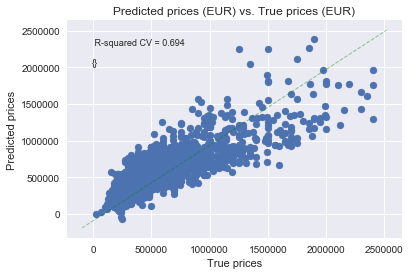

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] clf__n_neighbors=5 ..............................................
[CV] ............................... clf__n_neighbors=5, total=   0.0s
[CV] clf__n_neighbors=5 ..............................................
[CV] ............................... clf__n_neighbors=5, total=   0.0s
[CV] clf__n_neighbors=5 ..............................................
[CV] ............................... clf__n_neighbors=5, total=   0.0s
[CV] clf__n_neighbors=10 .............................................
[CV] .............................. clf__n_neighbors=10, total=   0.0s
[CV] clf__n_neighbors=10 .............................................
[CV] .............................. clf__n_neighbors=10, total=   0.0s
[CV] clf__n_neighbors=10 .............................................
[CV] .............................. clf__n_neighbors=10, total=   0.0s
[CV] clf__n_neighbors=15 .............................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.0s finished


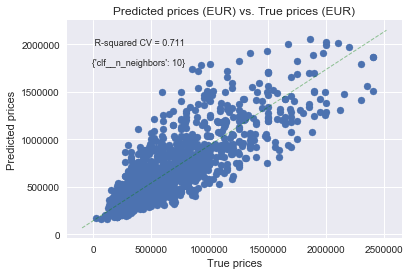

In [5]:
# Execute model hyperparameter tuning and crossvalidation

model(pipe_ols, param_ols, X_train, y_train, X, y)
model(pipe_knn, param_knn, X_train, y_train, X, y)